# Fitting interaction parameters for mixtures

---
Let's call $\underline{\xi}$ the optimization parameters of a mixture. In order to optimize them, you need to provide experimental phase equilibria data. This can include VLE, LLE and VLLE data. The objective function used for each equilibria type are shown below:


### Vapor-Liquid Equilibria Data


$$ OF_{VLE}(\underline{\xi}) = w_y \sum_{j=1}^{Np} \left[ \sum_{i=1}^c (y_{i,j}^{cal} - y_{i,j}^{exp})^2 \right] +  w_P \sum_{j=1}^{Np} \left[ \frac{P_{j}^{cal} - P_{j}^{exp}}{P_{j}^{exp}} \right]^2$$

Where, $Np$ is the number of experimental data points, $y_i$ is the vapor molar fraction of the component $i$ and $P$ is the bubble pressure. The superscripts $cal$ and $exp$ refers to the computed and experimental values, respectively. Finally, $w_y$ is the weight for the vapor composition error and $w_P$ is the weight for the bubble pressure error.


### Liquid-Liquid Equilibria Data
$$ OF_{LLE}(\underline{\xi}) = w_x \sum_{j=1}^{Np} \sum_{i=1}^c  \left[x_{i,j} - x_{i,j}^{exp}\right]^2 +  w_w \sum_{j=1}^{Np} \sum_{i=1}^c \left[ w_{i,j} - w_{i,j}^{exp}) \right]^2 $$

Where, $Np$ is the number of experimental data points, $x_i$ and $w_i$ are the molar fraction of the component $i$ on the liquids phases. The superscripts $cal$ and $exp$ refers to the computed and experimental values, respectively. Finally, $w_x$ and $w_w$ are the weights for the liquid 1 ($x$) and liquid 2 ($w$) composition error.


### Vapor-Liquid-Liquid Equilibria Data
$$ OF_{VLLE}(\underline{\xi}) = w_x \sum_{j=1}^{Np}  \sum_{i=1}^c  \left[x_{i,j}^{cal} - x_{i,j}^{exp}\right]^2 + w_w \sum_{j=1}^{Np}  \sum_{i=1}^c  \left[w_{i,j}^{cal} - w_{i,j}^{exp}\right]^2 +  w_y \sum_{j=1}^{Np}  \sum_{i=1}^c  \left[y_{i,j}^{cal} - y_{i,j}^{exp}\right]^2 + w_P \sum_{j=1}^{Np}  \left[ \frac{P_{j}^{cal}}{P_{j}^{exp}} - 1\right]^2 $$

Where, $Np$ is the number of experimental data points, $y_i$, $x_i$ and $w_i$ are the molar fraction of the component $i$ on the vapor and liquids phases, respectively. The superscripts $cal$ and $exp$ refers to the computed and experimental values, respectively. Finally, $w_x$ and $w_w$ are the weights for the liquid 1 ($x$) and liquid 2 ($w$) composition error, $w_y$ is the weight for vapor composition error and $w_P$ is weight for three phase equilibria pressure error.

If there is data for more than one equilibria type, the errors can be added accordinly. So the objective funcion becomes:

$$ OF(\underline{\xi}) =OF_{ELV}(\underline{\xi}) + OF_{ELL}(\underline{\xi}) + OF_{ELLV}(\underline{\xi})$$

---
This notebook has the purpose of showing examples of how to fit interaction parameters for binary mixtures using experimental equilibria data.

In [1]:
import numpy as np
from phasepy import component, mixture, prsveos

Now that the functions are available it is necessary to create the mixture.

In [2]:
water = component(name = 'Water', Tc = 647.13, Pc = 220.55, Zc = 0.229, Vc = 55.948, w = 0.344861,
                ksv = [ 0.87292043, -0.06844994],
                Ant =  [  11.72091059, 3852.20302815,  -44.10441047],
                cii = [ 1.16776082e-25, -4.76738739e-23,  1.79640647e-20],
                GC = {'H2O':1},
                ri=0.92, qi=1.4)

ethanol = component(name = 'Ethanol', Tc = 514.0, Pc = 61.37, Zc = 0.241, Vc = 168.0, w = 0.643558,
                ksv = [1.27092923, 0.0440421 ],
                Ant = [  12.26474221, 3851.89284329,  -36.99114863],
                cii = [ 2.35206942e-24, -1.32498074e-21,  2.31193555e-19],
                GC = {'CH3':1, 'CH2':1, 'OH(P)':1},
                ri=2.1055, qi=1.972)

mix = mixture(ethanol, water)

Now the experimental equilibria data is read and a tuple is created. It includes the experimental liquid composition, vapor composition, equilibrium temperature and pressure. This is done with ```datavle = (Xexp, Yexp, Texp, Pexp)```

If the mixture exhibits other equilibria types you can supply this experimental data to the ``datalle`` or ``datavlle`` parameters.

- ``datalle``: (Xexp, Wexp, Texp, Pexp)
- ``datavlle``: (Xexp, Wexp, Yexp, Texp, Pexp)

You specify the weights for each objetive function through the following parameters:

- ``weights_vle``: list or array_like, weights for the VLE objective function.
        - weights_vle[0] = weight for Y composition error, default to 1.
        - weights_vle[1] = weight for bubble pressure error, default to 1.
- ``weights_lle``: list or array_like, weights for the LLE objective function.
        - weights_lle[0] = weight for X (liquid 1) composition error, default to 1.
        - weights_lle[1] = weight for W (liquid 2) composition error, default to 1.
- ``weights_vlle``: list or array_like, weights for the VLLE objective function.
        - weights_vlle[0] = weight for X (liquid 1) composition error, default to 1.
        - weights_vlle[1] = weight for W (liquid 2) composition error, default to 1.
        - weights_vlle[2] = weight for Y (vapor) composition error, default to 1.
        - weights_vlle[3] = weight for equilibrium pressure error, default to 1.

Additionally, you can set options to the SciPy's ``minimize`` function using the ``minimize_options`` parameter.

In [3]:
#Vapor Liquid equilibria data obtanied from Rieder, Robert M. y A. Ralph Thompson (1949).
# «Vapor-Liquid Equilibria Measured by a GillespieStill - Ethyl Alcohol - Water System». 
#Ind. Eng. Chem. 41.12, 2905-2908.

#Saturation Pressure in bar
Pexp = np.array([1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013,
       1.013, 1.013, 1.013, 1.013, 1.013, 1.013, 1.013])

#Saturation temeprature in Kelvin
Texp = np.array([372.45, 370.05, 369.15, 369.15, 368.75, 367.95, 366.95, 366.65,
       366.05, 363.65, 363.65, 362.55, 361.55, 361.75, 360.35, 358.55,
       357.65, 357.15, 356.55, 356.15, 355.45, 355.15, 354.55, 354.65,
       354.35, 354.05, 353.65, 353.35, 353.15, 352.65, 351.95, 351.65,
       351.55, 351.45])

#Liquid fraction mole array
Xexp = np.array([[0.0028, 0.0118, 0.0137, 0.0144, 0.0176, 0.0222, 0.0246, 0.0302,
        0.0331, 0.0519, 0.053 , 0.0625, 0.0673, 0.0715, 0.0871, 0.126 ,
        0.143 , 0.172 , 0.206 , 0.21  , 0.255 , 0.284 , 0.321 , 0.324 ,
        0.345 , 0.405 , 0.43  , 0.449 , 0.506 , 0.545 , 0.663 , 0.735 ,
        0.804 , 0.917 ],
       [0.9972, 0.9882, 0.9863, 0.9856, 0.9824, 0.9778, 0.9754, 0.9698,
        0.9669, 0.9481, 0.947 , 0.9375, 0.9327, 0.9285, 0.9129, 0.874 ,
        0.857 , 0.828 , 0.794 , 0.79  , 0.745 , 0.716 , 0.679 , 0.676 ,
        0.655 , 0.595 , 0.57  , 0.551 , 0.494 , 0.455 , 0.337 , 0.265 ,
        0.196 , 0.083 ]])
#Vapor fraction mole array
Yexp = np.array([[0.032, 0.113, 0.157, 0.135, 0.156, 0.186, 0.212, 0.231, 0.248,
        0.318, 0.314, 0.339, 0.37 , 0.362, 0.406, 0.468, 0.487, 0.505,
        0.53 , 0.527, 0.552, 0.567, 0.586, 0.586, 0.591, 0.614, 0.626,
        0.633, 0.661, 0.673, 0.733, 0.776, 0.815, 0.906],
       [0.968, 0.887, 0.843, 0.865, 0.844, 0.814, 0.788, 0.769, 0.752,
        0.682, 0.686, 0.661, 0.63 , 0.638, 0.594, 0.532, 0.513, 0.495,
        0.47 , 0.473, 0.448, 0.433, 0.414, 0.414, 0.409, 0.386, 0.374,
        0.367, 0.339, 0.327, 0.267, 0.224, 0.185, 0.094]])

datavle = (Xexp, Yexp, Texp, Pexp)

## Fitting QMR mixing rule 

As a scalar is been fitted, SciPy recommends giving a certain interval where the minimum could be found, the function ```fit_kij``` handles this optimization. 

In [4]:
from phasepy.fit import fit_kij

mixkij = mix.copy()
fit_kij((-0.15, -0.05), prsveos, mixkij, datavle)

     fun: 0.1660630616839396
    nfev: 17
     nit: 13
 success: True
       x: -0.10726855015061496

## Fitting NRTL interaction parameters 

As an array is been fitted, multidimensional optimization algorithms are used, the function ```fit_nrtl``` handles this optimization with several options available. If a fixed value of the aleatory factor is used the initial guess has the following form:

nrtl0 = np.array([A12, A21])

If the aleatory factor needs to be optimized it can be included setting alpha_fixed to False, in this case, the initial guess has the following form:

nrtl0 = np.array([A12, A21, alpha])

Temperature-dependent parameters can be fitted setting the option Tdep = True in ```fit_nrtl```, when this option is used the parameters are computed as:

$$
A12 = A12_0 + A12_1  T \\
A21 = A21_0 + A21_1  T
$$

The initial guess passed to the fit function has the following form:

nrtl0 = np.array([A12_0, A21_0, A12_1, A21_1, alpha])

or, if alpha fixed is used.

nrtl0 = np.array([A12_0, A21_0, A12_1, A21_1])

In [5]:
from phasepy.fit import fit_nrtl
mixnrtl = mix.copy()

#Initial guess of A12, A21
nrtl0 = np.array([-80.,  650.])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = True)
#optimized values
[-84.77530335, 648.78439102]

#Initial guess of A12, A21
nrtl0 = np.array([-80.,  650.,  0.2])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = False)
#optimized values for A12, A21, alpha
# [-5.53112687e+01,  6.72701992e+02,  3.19740734e-01]

      fun: 0.006466986505079838
 hess_inv: array([[1.93665947e+04, 1.78081758e+04, 5.51974628e+01],
       [1.78081758e+04, 1.63770077e+04, 5.07592808e+01],
       [5.51974628e+01, 5.07592808e+01, 2.29596154e-01]])
      jac: array([-2.76789069e-06,  2.99297972e-06,  4.61988384e-06])
  message: 'Optimization terminated successfully.'
     nfev: 104
      nit: 24
     njev: 26
   status: 0
  success: True
        x: array([-5.53138695e+01,  6.72698956e+02,  3.19746008e-01])

By default Tsonopoulos virial correlation is calculated for vapor phase, if desired ideal gas or Abbott correlation can be used.

In [6]:
#Initial guess of A12, A21
nrtl0 = np.array([-80.,  650.])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = True, virialmodel = 'ideal_gas')

      fun: 0.007558470882914061
 hess_inv: array([[ 212932.81699919, -343660.55714058],
       [-343660.55714058,  589991.97517176]])
      jac: array([1.23691279e-06, 9.03615728e-07])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 24
     njev: 32
   status: 0
  success: True
        x: array([-225.18006096,  859.0016657 ])

In [7]:
#Initial guess of A12, A21
nrtl0 = np.array([-80.,  650.])
fit_nrtl(nrtl0, mixnrtl, datavle, alpha_fixed = True, virialmodel = 'Abbott')

      fun: 0.007160659619871076
 hess_inv: array([[ 201255.12516345, -326683.66016491],
       [-326683.66016491,  565149.03611937]])
      jac: array([8.36327672e-07, 3.85043677e-07])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 24
     njev: 32
   status: 0
  success: True
        x: array([-226.48106059,  866.22097443])

## Fitting Wilson interaction parameters 

As an array is been fitted, multidimensional optimization algorithms are used, the function ```fit_wilson``` handles this optimization. 

In [8]:
from phasepy.fit import fit_wilson

mixwilson = mix.copy()
#Initial guess of A12, A21
wilson0 = np.array([-80.,  650.])
fit_wilson(wilson0, mixwilson, datavle)

      fun: 0.005778735713812315
 hess_inv: array([[ 342744.06168558, -176133.37552057],
       [-176133.37552057,  111198.19052628]])
      jac: array([ 3.39525286e-07, -8.99308361e-07])
  message: 'Optimization terminated successfully.'
     nfev: 102
      nit: 24
     njev: 34
   status: 0
  success: True
        x: array([147.30295044, 499.94358376])

Similarly as when fitting nrtl parameters, Tsonopoulos virial correlation is used by default. Ideal gas or Abbott correlation can be used.

In [9]:
fit_wilson(wilson0, mixwilson, datavle, virialmodel = 'ideal_gas')

      fun: 0.0065406955473037605
 hess_inv: array([[ 362077.88266564, -170676.96490137],
       [-170676.96490137,   97626.77928563]])
      jac: array([-8.80321022e-06,  7.25907739e-06])
  message: 'Optimization terminated successfully.'
     nfev: 99
      nit: 23
     njev: 33
   status: 0
  success: True
        x: array([136.15390922, 501.94739033])

## Fitting Redlich-Kister interaction parameters 

As an array is been fitted, multidimensional optimization algorithms are used, the function ```fit_rk``` handles this optimization. Redlich-Kister expansion is programmed for n terms of the expansion, this fitting function will optimize considering the length of the array passed as an initial guess.

If rk0 is a scalar it is reduced to Porter model, if it is an array of size 2 it reduces to Margules Model.

Temperature-dependent parameters can be fitted in which case the initial guess will split into two arrays.

``c, c1 = np.split(rk0, 2) ``

Finally, the parameters are computed as:

G = c + c1/T

In [10]:
from phasepy.fit import fit_rk
mixrk = mix.copy()
rk0 = np.array([0, 0])
fit_rk(rk0, mixrk, datavle, Tdep =  False)

      fun: 0.011409101217688289
 hess_inv: array([[0.22226423, 0.2216714 ],
       [0.2216714 , 0.59011921]])
      jac: array([-1.33074354e-06,  7.45872967e-07])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([ 1.17598058, -0.44485443])

In [11]:
fit_rk(rk0, mixrk, datavle, Tdep =  False, virialmodel = 'ideal_gas')

      fun: 0.01162334362223118
 hess_inv: array([[0.23059474, 0.23033851],
       [0.23033851, 0.60414725]])
      jac: array([-1.17497984e-06,  6.71832822e-07])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([ 1.16856434, -0.43871565])

## Fitting UNIQUAC interaction parameters 


As an array is been fitted, multidimensional optimization algorithms are used, the function ```fit_uniquac``` handles this optimization. If constant interaction energies are been considered, the initial guess has the following form:

A0 = np.array([A12, A21])

Temperature-dependent parameters can be fitted setting the option Tdep = True in ```fit_uniquac```, when this option is used the interaction energies are computed as:

$$
A12 = A12_0 + A12_1  T \\
A21 = A21_0 + A21_1  T
$$

The initial guess passed to the fit function has the following form:

A0 = np.array([A12_0, A21_0, A12_1, A21_1])


**note:** you need to provide the molecular surface and volume (``ri`` and ``qi``) to the components for this method to work.

In [12]:
from phasepy.fit import fit_uniquac

mixuniquac = mix.copy()

# initial guesses for the interaction energies (in K)
A0 = np.array([100., 200])
fit_uniquac(A0, mixuniquac, datavle)

      fun: 0.0056378686986078485
 hess_inv: array([[ 334102.31495179, -394511.30962664],
       [-394511.30962664,  473322.41102935]])
      jac: array([ 1.12340786e-07, -6.34463504e-09])
  message: 'Optimization terminated successfully.'
     nfev: 108
      nit: 31
     njev: 36
   status: 0
  success: True
        x: array([ -7.33540823, 151.83100234])

After the optimizations have been carried out, fitted data can be compared against experimental data.

In [13]:
from phasepy import virialgamma
from phasepy.equilibrium import bubbleTy

prkij = prsveos(mixkij)
virialnrtl = virialgamma(mixnrtl, actmodel = 'nrtl')
virialwilson = virialgamma(mixwilson, actmodel = 'wilson')
virialrk = virialgamma(mixrk, actmodel = 'rk')
virialuniquac = virialgamma(mixuniquac, actmodel='uniquac')

Ykij = np.zeros_like(Yexp)
Tkij = np.zeros_like(Pexp)
Ynrtl = np.zeros_like(Yexp)
Tnrtl = np.zeros_like(Pexp)
Ywilson = np.zeros_like(Yexp)
Twilson = np.zeros_like(Pexp)
Yrk = np.zeros_like(Yexp)
Trk = np.zeros_like(Pexp)
Yuniquac = np.zeros_like(Yexp)
Tuniquac = np.zeros_like(Pexp)


n = len(Pexp)

for i in range(n):
    Ykij[:,i],Tkij[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],prkij)
    Ynrtl[:,i],Tnrtl[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialnrtl)
    Ywilson[:,i],Twilson[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialwilson)
    Yrk[:,i],Trk[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialrk)
    Yuniquac[:,i],Tuniquac[i] = bubbleTy(Yexp[:,i],Texp[i],Xexp[:,i],Pexp[i],virialuniquac)

<ipython-input-14-7000fe8ab98a>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


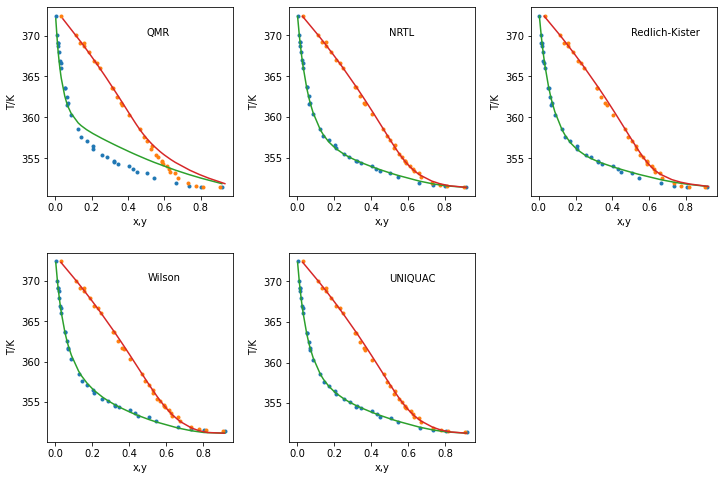

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

ax=fig.add_subplot(231)
ax.plot(Xexp[0], Texp,'.', Yexp[0], Texp,'.')
ax.plot(Xexp[0], Tkij, Ykij[0], Tkij)
ax.set_xlabel('x,y')
ax.set_ylabel('T/K')
ax.text(0.5, 370, 'QMR')

ax2 = fig.add_subplot(232)
ax2.plot(Xexp[0], Texp,'.', Yexp[0], Texp,'.')
ax2.plot(Xexp[0], Tnrtl, Ynrtl[0], Tnrtl)
ax2.set_xlabel('x,y')
ax2.set_ylabel('T/K')
ax2.text(0.5, 370, 'NRTL')

ax3 = fig.add_subplot(233)
ax3.plot(Xexp[0], Texp,'.', Yexp[0], Texp,'.')
ax3.plot(Xexp[0], Trk, Yrk[0], Trk)
ax3.set_xlabel('x,y')
ax3.set_ylabel('T/K')
ax3.text(0.5, 370, 'Redlich-Kister')

ax4 = fig.add_subplot(234)
ax4.plot(Xexp[0], Texp,'.', Yexp[0], Texp,'.')
ax4.plot(Xexp[0], Twilson, Ywilson[0], Twilson)
ax4.set_xlabel('x,y')
ax4.set_ylabel('T/K')
ax4.text(0.5, 370, 'Wilson')

ax5 = fig.add_subplot(235)
ax5.plot(Xexp[0], Texp,'.', Yexp[0], Texp,'.')
ax5.plot(Xexp[0], Tuniquac, Yuniquac[0], Tuniquac)
ax5.set_xlabel('x,y')
ax5.set_ylabel('T/K')
ax5.text(0.5, 370, 'UNIQUAC')

fig.show()

For further information please also check [official documentation](https://phasepy.readthedocs.io/), or just try:

```function?```